In [1]:
# project
import os
import sys 
project_dir = os.path.join(os.path.expanduser('~'), 'git', 'diffsim-sysid')
sys.path.insert(1, project_dir)
# physics
import warp as wp
# graphics
import mitsuba as mi
# plots
from matplotlib import pyplot as plt
from src.mpl_utils import set_fig_size, set_mpl_format
# config
from src.config import cfg
# dataset
from src.sim import Sample
from src.dataset import load_train_data

# setup
set_mpl_format()
wp.init()
mi.set_variant('llvm_ad_rgb')
print(f'Mitsuba 3 Variant: {mi.variant()}')

2024-04-05 21:38:13.107374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Warp 1.0.2 initialized:
   CUDA Toolkit 11.5, Driver 11.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce GTX 1050 Ti with Max-Q Design" (4 GiB, sm_61, mempool enabled)
   Kernel cache:
     /home/jonathan/.cache/warp/1.0.2
Mitsuba 3 Variant: llvm_ad_rgb


### Config

In [2]:
# fill in your directory set up here
config_fp = os.path.join(project_dir, f'cfg/templates/comp-movi_a.yaml')
cfg.merge_from_file(config_fp)
cfg.path = project_dir
cfg.DATA.path = os.path.join(project_dir, 'data/sets/')
print(cfg)

DATA:
  fps: 12
  fpv: 24
  height: 256
  max_objs: 10
  path: /home/jonathan/git/diffsim-sysid/data/sets/
  set: movi_a
  width: 256
EVAL:
  OUTPUT:
    FN:
      config: config.yaml
      log: log.txt
      pred: pred.csv
    path: 
  PARAM:
    DENSITY:
      include: True
      prior: 1.35
    FRICTION:
      include: True
      prior: 0.5
    RESTITUTION:
      include: True
      prior: 0.5
SYS_ID:
  GEOM:
    include: True
    spm: 100
  OPTIM:
    beta1: 0.9
    beta2: 0.999
    decay: 0.0
    lr: 0.01
    optim: adam
  VIS:
    include: True
    spp: 4
    weight: 1.0
  iter: 4
  rand: False
path: /home/jonathan/git/diffsim-sysid


### Data

In [3]:
train_ds, ds_info = load_train_data(cfg)
example = next(iter(train_ds))
time_step = 20
vid_id = example['metadata']['video_name']
print(f'Video: {vid_id}')

2024-04-05 21:38:18.709933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-05 21:38:18.714499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-05 21:38:18.714793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-05 21:38:18.716498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Video: b'1680'


### Rendering

In [4]:
sim = Sample(cfg, example)
recon_dict = sim.get_render_orig_timestep_dict(time_step)
recon_img = mi.render(mi.load_dict(recon_dict), spp=64)

our_dict = sim.get_render_timestep_dict(-1)
our_img = mi.render(mi.load_dict(our_dict), spp=64)

Warp DeprecationWarning: Support for built-in functions called with non-Warp array types, such as lists, tuples, NumPy arrays, and others, will be dropped in the future. Use a Warp type such as `wp.vec`, `wp.mat`, `wp.quat`, or `wp.transform`.
Module warp.sim.collide load on device 'cuda:0' took 36452.89 ms
Module warp.sim.integrator_euler load on device 'cuda:0' took 14279.53 ms
Module warp.sim.integrator load on device 'cuda:0' took 845.80 ms


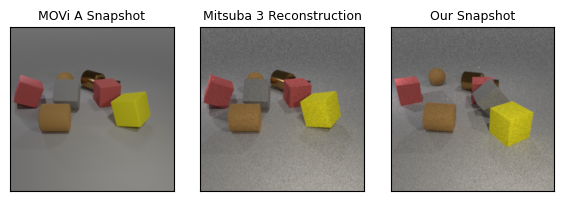

In [5]:
fig_size = set_fig_size(subplots=(1, 3))
fig, axs = plt.subplots(1, 3, figsize=fig_size, constrained_layout=True)


movi_img = example['video'][time_step]
axs[0].imshow(movi_img)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('MOVi A Snapshot')

scene_bitmap = mi.util.convert_to_bitmap(recon_img)
axs[1].imshow(scene_bitmap)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Mitsuba 3 Reconstruction')

scene_bitmap = mi.util.convert_to_bitmap(our_img)
axs[2].imshow(scene_bitmap)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Our Snapshot')

plt.show()
#plt.savefig('fig_movi_a_mitsuba.pdf', bbox_inches='tight')

In [ ]:
# # for backprop
# def run_phys(model, integrator, states):
#     # computation graph
#     tape = wp.Tape()
#     with tape:
#         for i in range(SIM_STEPS):
#             states[i].clear_forces()
#             wp.sim.collide(model, states[i])
#             integrator.simulate(model, states[i], states[i + 1], SIM_DT)

#     return tape